In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

from Funcoes_gerais import funcoes

root_dir = f"/home/adriano/projeto_mestrado/modules"

tracados_bezier = f'{root_dir}/Artificial_Lines/tracados_bezier/'

img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'

def bezier(points, precision):
    ts = np.linspace(0, 1, precision)
    B = np.zeros((len(ts), 2), dtype=np.float64)
    n = len(points) - 1
    for idx, t in enumerate(ts):
        for i in range(n+1):
            bin_coef = np.math.factorial(n) / (np.math.factorial(i) * np.math.factorial(n-i))
            Pin = bin_coef * (1-t)**(n-i) * t**i
            B[idx] += Pin * points[i]

    return B

def criando_pontos(tam):
    points = []
    while len(points)<tam:
        p1x = np.random.randint(0,1376)   
        p1y = np.random.randint(0,1104)   
        p2x = np.random.randint(0,1376) 
        p2y = np.random.randint(0,1104)  
        distancia = np.sqrt((p1x-p2x)**2 + (p1y-p2y)**2)
        if distancia > 500:
            p1 = np.array((p1x,p1y))
            p2 = np.array((p2x,p2y))
            p = np.vstack((p1, p2))        
            points.append(p)
    return points

In [2]:
# Sorteando curvas aleatórias

pontos = criando_pontos(5)
array_curves = []
for i in range(len(pontos)):
    ps = pontos[i][0] # ponto inicial   
    pe = pontos[i][1] # ponto final 
    dx = pe[0]-ps[0]
    dy = pe[1]-ps[1]
    distancia = np.sqrt((pe[0]-ps[0])**2 + (pe[1] - ps[1])**2)
    normal_se = np.array((-dy, dx))/distancia #ou (dy, -dx) --> vetor normal à (pe-ps)
    max_vd = 500 # distancia máxima em que os pontos de controle serão sorteados (usar entre 0 e 1)
    n_points = 6 # numero de pontos de controle entre pe e ps 

    control_points = []
    hds = np.linspace(0.2, 0.8, n_points) # faz com que os pontos de controle sejam equidistantes em relação à (pe-ps)

    for i in range(n_points):    
        # control_point = (pe-ps) * np.random.uniform(low=0.2, high=0.8)
        control_point = ((pe-ps) * hds[i]) # setar as distancias horizontais dessa maneira deixa um aspecto mais natural
        control_point += (normal_se * np.random.uniform(low=-1, high=1) * max_vd)
        control_points.append(control_point+ps)

    control_points.insert(0, ps)
    control_points.append(pe)
    curve = bezier(control_points, precision=100)
    array_curves.append(curve)


In [3]:
# i = 1
for i in range(20):
# arquivo = f'{root_dir}/Vetores_Extraidos_json/teste{imag}.json'
#funcoes.gravar_array_arquivo(curve,f'/home/adriano/projeto_mestrado/modules/Artificial_Lines/tracados_bezier/{img_especifica}_savedata_{i}.json')
    funcoes.gravar_array_arquivo(array_curves,f'{tracados_bezier}{img_especifica}_savedata_{i}.json')   

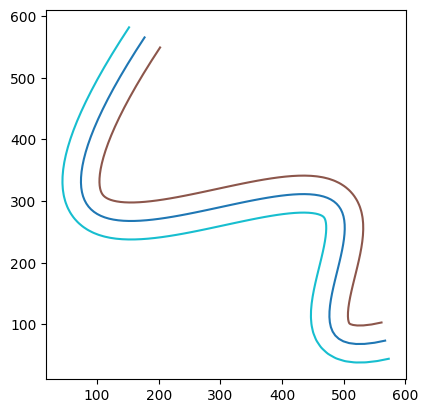

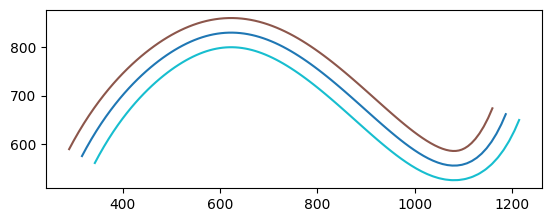

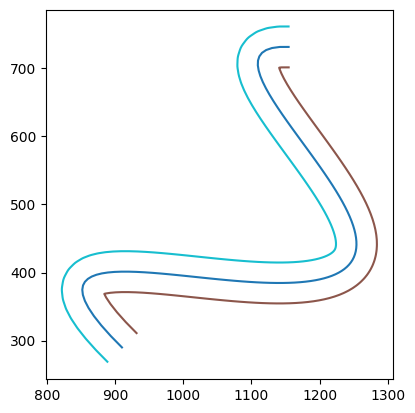

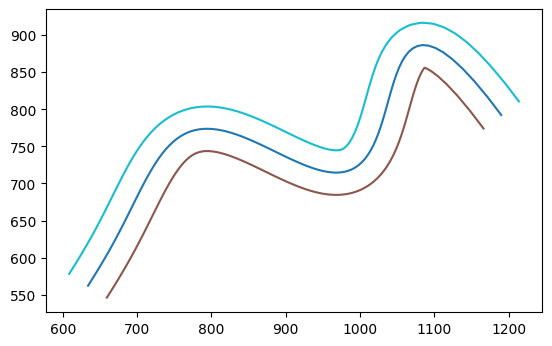

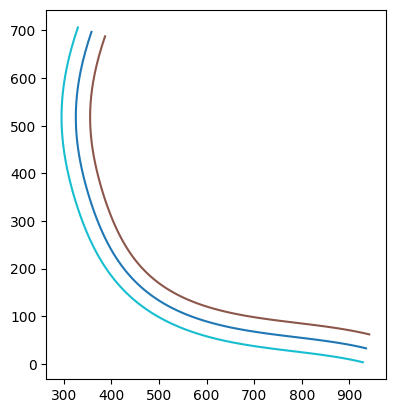

In [4]:
from Background import background_generation as backgen
from geopandas import gpd

for i in range(len(array_curves)):    
    #caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_curves[i], 2) # type: ignore

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_curves[i],30)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")


In [5]:
tracados = f'{root_dir}/Artificial_Lines/tracados_bezier/{img_especifica}_savedata_1.json'
array_medial_path = backgen.retorna_paths(tracados)

In [6]:
array_medial_path

[array([[569.        ,  74.        ],
        [550.09794808,  70.23036933],
        [533.91867362,  68.35844282],
        [520.24311776,  68.22356756],
        [508.85878584,  69.66976822],
        [499.56000473,  72.54596734],
        [492.14815114,  76.70618223],
        [486.43185167,  82.00969923],
        [482.22715546,  88.32122587],
        [479.35768026,  95.51102161],
        [477.65473262, 103.45500786],
        [476.9574032 , 112.03485789],
        [477.1126378 , 121.13806727],
        [477.97528508, 130.65800549],
        [479.4081217 , 140.49394941],
        [481.28185572, 150.55109927],
        [483.47510902, 160.74057776],
        [485.87437967, 170.97941289],
        [488.37398488, 181.19050535],
        [490.8759855 , 191.30258086],
        [493.2900928 , 201.25012838],
        [495.53355838, 210.97332457],
        [497.53104795, 220.41794537],
        [499.21449987, 229.53526527],
        [500.52296923, 238.2819448 ],
        [501.40245825, 246.61990718],
        [501

In [7]:
# plt.figure(figsize=(10, 10))
# xs, ys = list(zip(*control_points))
# plt.scatter(xs, ys, color="blue")
# plt.scatter(ps[0], ps[1], color="red")
# plt.scatter(pe[0], pe[1], color="red")
# xs, ys = list(zip(*curve))
# plt.plot(xs, ys)
# plt.xlim((0,1376))
# plt.ylim((0,1104))